In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2

In [4]:
df=pd.read_csv(r'C:\Users\79375\Desktop\DS\Tesla Stock\Price_Tesla.csv', sep=';')
df

,Date,Price,Open,Max,Min
0,22.10.2020,425.79,442.15,444.74,424.72
1,21.10.2020,422.64,423.25,432.90,421.25
2,20.10.2020,421.94,430.91,430.91,419.10
3,19.10.2020,430.83,445.74,446.60,428.93
4,16.10.2020,439.67,454.44,455.95,438.85
...,...,...,...,...,...
1923,07.03.2013,7.65,7.55,7.73,7.38
1924,06.03.2013,7.54,7.40,7.58,7.39
1925,05.03.2013,7.33,7.20,7.38,7.16
1926,04.03.2013,7.12,6.95,7.17,6.94


In [5]:
# df['Date']=pd.to_datetime(df['Date'])

In [6]:
def to_datetime(df):
    date=datetime.strptime(df, '%d.%m.%Y')
    return date.strftime('%Y-%m-%d')

In [7]:
df['Date']=df['Date'].apply(lambda x: to_datetime(x))

In [8]:
df=df.sort_values('Date').reset_index(drop=True)

In [9]:
df.head(10)

,Date,Price,Open,Max,Min
0,2013-03-01,6.93,7.00,7.20,6.85
1,2013-03-04,7.12,6.95,7.17,6.94
2,2013-03-05,7.33,7.20,7.38,7.16
3,2013-03-06,7.54,7.40,7.58,7.39
4,2013-03-07,7.65,7.55,7.73,7.38
5,2013-03-08,7.69,7.61,7.89,7.47
6,2013-03-11,7.82,7.77,7.89,7.73
7,2013-03-12,7.82,7.78,7.88,7.77
8,2013-03-13,7.80,7.80,7.90,7.76
9,2013-03-14,7.37,7.78,7.78,7.35


In [10]:
num_shape=1900

train=df.iloc[:num_shape,1:2].values
test=df.iloc[num_shape:,1:2].values

In [11]:
sc=MinMaxScaler(feature_range=(0,1))
train_scaled=sc.fit_transform(train)

In [12]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)   

In [13]:
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['MeanSquaredError'])
model.fit(X_train,y_train,epochs=1000,batch_size=32)

Epoch 1/1000
58/58 [==============================] - 10s 64ms/step - loss: 6.5412e-04 - mean_squared_error: 6.5412e-04
Epoch 2/1000
58/58 [==============================] - 4s 62ms/step - loss: 5.8248e-04 - mean_squared_error: 5.8248e-04
Epoch 3/1000
58/58 [==============================] - 4s 62ms/step - loss: 6.0164e-04 - mean_squared_error: 6.0164e-04A: 0s - loss: 6.0902e-04 - me
Epoch 4/1000
58/58 [==============================] - 4s 62ms/step - loss: 5.4438e-04 - mean_squared_error: 5.4438e-04
Epoch 5/1000
58/58 [==============================] - 4s 70ms/step - loss: 5.5469e-04 - mean_squared_error: 5.5469e-04
Epoch 6/1000
58/58 [==============================] - 4s 68ms/step - loss: 6.7293e-04 - mean_squared_error: 6.7293e-04
Epoch 7/1000
58/58 [==============================] - 4s 70ms/step - loss: 6.8999e-04 - mean_squared_error: 6.8999e-04
Epoch 8/1000
58/58 [==============================] - 4s 68ms/step - loss: 7.3402e-04 - mean_squared_error: 7.3402e-04
Epoch 9/1000
58/58

KeyboardInterrupt: 

In [31]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [32]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

In [39]:
diff=predict-test

print("MSE:", np.mean(diff**2))
print('MAE:',np.mean(abs(diff)))
print("RMSE:",np.sqrt(np.mean(diff**2)))


MSE: 5016.3558021794515
MAE: 63.19550127301898
RMSE: 70.82623667949224


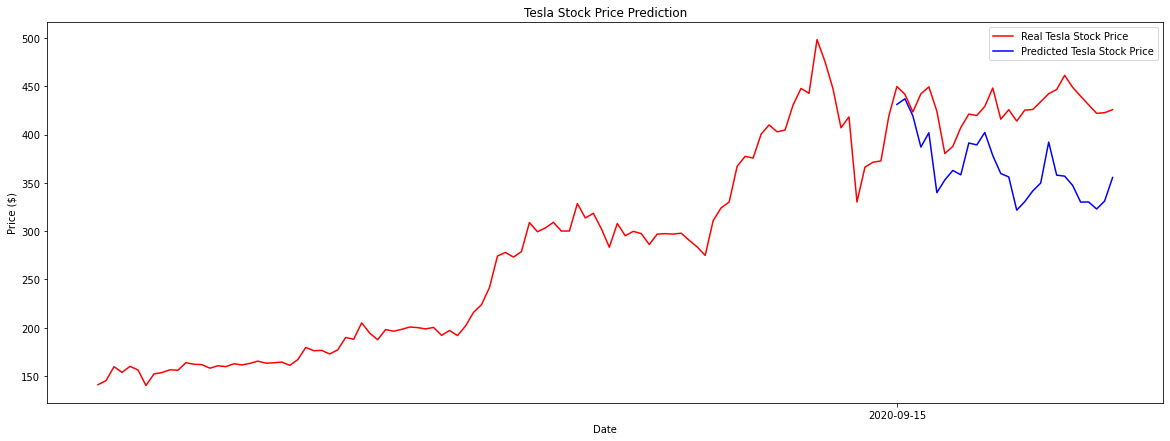

In [44]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1800:], df_volume[1800:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df[1800:].shape[0],200))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [45]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [46]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [47]:
df_date = df[['Date']]

for h in range(20):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

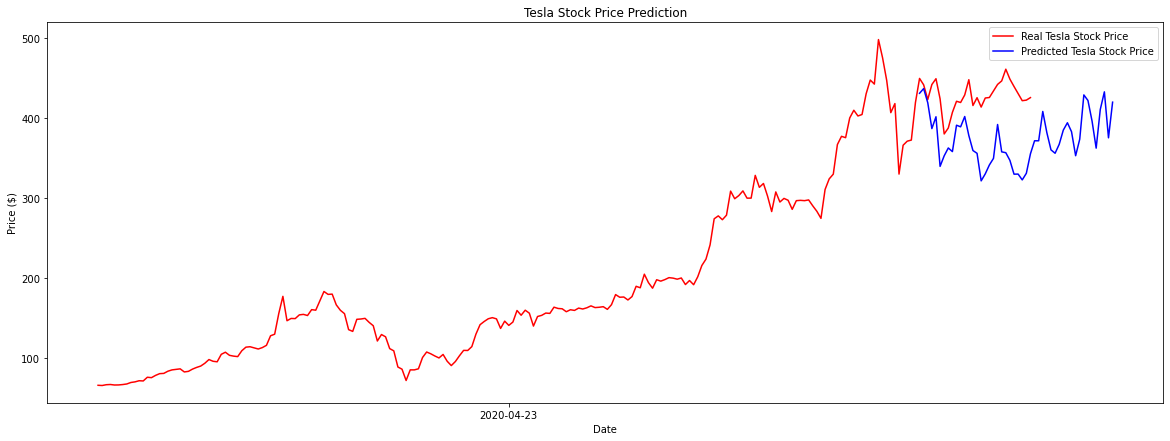

In [48]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df[1700:].shape[0],200))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()